# План работ
1. Импортируем необходимые дял работы библиотеки
2. Подключимся к файлу данных, размещённому по следующему адресу: `/datasets/users_behavior.csv`.
3. Произведём разделение исходных данные на обучающую, валидационную и тестовую выборки.
4. Проведём исследование качества разных моделей, изменяя гиперпараметры.
5. Проверим качество модели на тестовой выборке, с подобранными гиперпараметрами.
6. Проведём проверку модели на вменяемость.

# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Описание данных:**
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

### Подключаем библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV  # Автоматический подбор гиперпараметров
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt  
import pandas as pd  
import seaborn as sns

### Подключаемся к файлу

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')

### Проводим первичный анализ DataFrame

- Использование `shape()` позволяет оценить размеры таблицы с данными (количество строк и столбцов);<br>
- Использование `head()` и `tail()` позволяет визуально посмотреть на данные таблицы;<br>
- Использование `info()` позволяет получить информацию о структуре данных; информацию об индексах; названиях столбцов; количества нулевых значений; типы данных и какие типы данных входят в df.<br>
- Использование `duplicated()` позволяет проверить наличие в данных полных дублей, которые могут внести негативные искажения в качество и точности конечного результата исследования.<br> 

Вышеперечисленные методы анализа данных, в первую очередь требуется для того, чтобы выбрать тактику работы с таблицей - придётся ли обработывать данные, прежде чем начать их анализировать и использовать в ML обучении.

In [3]:
# Определяем размерах таблицы с данными (количество строк и столбцов) в DataFrame
df.shape

(3214, 5)

In [4]:
# Выводим первые 5 строк
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
# Выводим последние 5 строк
df.tail()

,calls,minutes,messages,mb_used,is_ultra
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0
3213,80.0,566.09,6.0,29480.52,1


In [6]:
# Определяем наличие нулевых значений и типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [7]:
# Проверяем количество полных дубликатов
duplicated = df.duplicated().sum()
print(f'Найдено {duplicated} полных дубликатов.')

Найдено 0 полных дубликатов.


In [8]:
# Проводим проверку на наличие дисбаланса в данных
df_sum = df['is_ultra'].sum()
df_count = df['is_ultra'].count()
print(f'Доля клиентов, подключённых к тарифному плану "Ультра" составляет: {(df_sum / df_count * 100):.2f}%, \
от общего количества записей в данных.')

Доля клиентов, подключённых к тарифному плану "Ультра" составляет: 30.65%, от общего количества записей в данных.


**Полученный результат 30,65% свидетельствует о несбалансированности данных**

**Сформируем и выведем тепловую карту корреляции признаков DataFrame.**

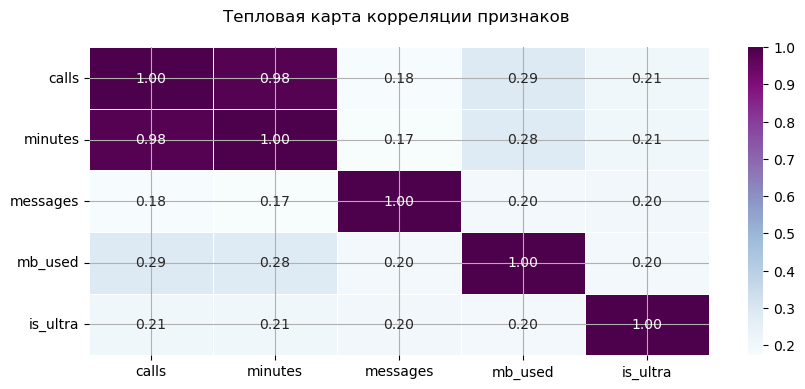

In [9]:
plt.figure(figsize=(10, 4))  # Задаём размер тепловой карты
sns.heatmap(df.corr(), # 
            annot=True, # Отображение цифровых значений
            fmt=".2f",   # Округляем значения
            linewidth=.5, # Задём расстояние между ячейками
            cmap="BuPu")  # Задаём цветовую схему (crest, YlGnBu, Blues, BuPu, Greens)
plt.title('Тепловая карта корреляции признаков \n')
plt.grid(True)
plt.show()

`Звонки` и `минуты` имеют сильную зависимость между собой, их **коэффициент корреляции равен 0.98** что говорит о сильной положительной зависимости этих факторов друг от друга. С учётом наличия сильной связи между этими признаками можно говорить о наличии `мультиколлениарности в DataFrame`.

- По результатам анализа данных, установлено что, в направленных для анализа данных отсутствуют пропуски данных, отсутсвуют дубликаты значений и типы данных определены корректно, что в свою очередь свидетельствует о том, что данные корректные и их можно использовать в исследовательской работе.<br>
- В направленных для анализа данные имеется целевой признак, который нужно предсказать по остальным признакам, — тип тарифа `is_ultra`. Подобные задачи относятся к классу «`обучение с учителем`» (от англ. supervised learning). В текущей задаче целевой признак принимает значение 0 или 1, т.е. `является бинарным значением` и в соответствии с этим, будет решаться `категориальная` задача классификации.
- С учётом **30.65%** доли клиентов, подключённых к тарифному плану "Ультра" от общего количества записей в данных, делается вывод о наличии `Несбалансированной` задачи классификации.
- Баланс классов в исследовании проанализирован и принято решение отказаться от использования методов балансировки классов, т.к. получаемый результат уступает результатам получаемых без их использования. 
- Для проверки корреляции признаков были использованы коээфициенты корреляции Мэтьюса.
- Этапы по устранению Мультиколлинеарности не применялись, т.к. в конечном итоге из-за низких показателей полученных в модели Линейной регрессии (менее 0,75) от использования её в дальнейшем исследовании пришлось отказаться.

## Разбейте данные на выборки

In [10]:
# Создаём переменную features (особенности), которая не содержит целевого столбца is_ultra
features = df.drop(['is_ultra'], axis=1)
# Создаём переменную target (цель), которая содержит только с целевой столбцец данных is_ultra 
target = df['is_ultra']

In [11]:
# Используем объект Counter, чтобы подсчитать представителей каждого класса
counter = Counter(target)
print(counter)

Counter({0: 2229, 1: 985})


**Полученный результат {{0: 2229, 1:985}}, подтверждает несбалансированность данных.**

### Разделяем исходные данные на обучающую, валидационную и тестовую выборки.

По условиям задачи разбиваем выборки на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов делаем равными. 

In [12]:
# Создаём функцию разделения выборки на три части
# Воспроизводимость результатов разбиения выборки на обучающую (тренировочную) / тестовую / валидационную мы обеспечили (фиксированием значения 
# "random_state"), значит при всех последующих запусках нашего кода подвыборки будут идентичными.
def train_valid_test_split(features, target, train_size, random_state=12345):
    """
    Функция разделяет выборку на три части: тренировочную, валидационную и тестовую.

    Args:
        features: Входные данные (признаки).
        target: Целевые значения.
        train_size: Размер тренировочной выборки (доля от 1.0).
        random_state: Состояние генератора случайных чисел для воспроизводимости.

    Returns:
        X_train: Тренировочные признаки.
        y_train: Тренировочные целевые значения.
        X_valid: Валидационные признаки.
        y_valid: Валидационные целевые значения.
        X_test: Тестовые признаки.
        y_test: Тестовые целевые значения.
    """
    # Определяем долю для валидационной и тестовой выборок
    valid_test = 1 / 2
    # Разделяем данные на тренировочную и остальные выборки
    X_train, X_others, y_train, y_others = train_test_split(features, 
                                                    target,
                                                    stratify=target, # Сохраняем пропорции целевого столбца
                                                    train_size=train_size, 
                                                    random_state=random_state)
    # Разделяем остальные данные на валидационную и тестовую выборки
    X_valid, X_test, y_valid, y_test = train_test_split(X_others, 
                                                    y_others,
                                                    stratify=y_others, # Сохраняем пропорции целевого столбца
                                                    train_size=valid_test, # Доля для валидационной выборки
                                                    random_state=random_state)
    # Возвращаем три части выборки
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [13]:
# Вызываем функцию разделения на тренировочну, валидную и тестовую выборки
# Валидная и тестовая выборки имеют равные размеры
X_train, y_train, X_valid, y_valid, X_test, y_test = \
                train_valid_test_split(features, target, train_size=0.6)

### Анализируем созданные наборы данных 

После разбиения данных на выборки проанализируем получившиеся размеры и размерности выборок. "Цифры" по выборкам показывают верно ли мы произвели "разделение" данных.

X_train.shape[0] – «покажет» количество строк в тренировочной выборке, а X_train.shape[1] - количество столбцов в ней же. Ну а X_train.shape – выведет размерность train'а в виде кортежа с 2мя значениями (первое число – количество строк, второе – столбцов).

In [14]:
# Проверяем размерность тренировочной, валидной и тестовой выборок
variables = [X_train, y_train, X_valid, y_valid, X_test, y_test]
for i in variables:
    print(i.shape[0])

1928
1928
643
643
643
643


In [15]:
# Проверяем размерность тренировочной, валидной и тестовой выборок
variables = [y_train, y_valid, y_test]
for i in variables:
#     print(i.head())
    # Проводим проверку на наличие дисбаланса в данных
    df_sum = i.sum()
    df_count = i.count()
    print(f'Доля клиентов, подключённых к тарифному плану "Ультра" составляет: {(df_sum / df_count * 100):.2f}%.')


Доля клиентов, подключённых к тарифному плану "Ультра" составляет: 30.65%.
Доля клиентов, подключённых к тарифному плану "Ультра" составляет: 30.64%.
Доля клиентов, подключённых к тарифному плану "Ультра" составляет: 30.64%.


In [16]:
# Используем объект Counter, чтобы подсчитать представителей каждого класса и удостовериться, 
# что преобразованный набор данных был создан правильно.
samples = {'y_train': y_train, 'y_valid': y_valid, 'y_test': y_test}
for key, meaning in samples.items():
    counter = Counter(meaning)
    print(f'{key} содержит: {counter}')

y_train содержит: Counter({0: 1337, 1: 591})
y_valid содержит: Counter({0: 446, 1: 197})
y_test содержит: Counter({0: 446, 1: 197})


Созданные наборы данных **разделились равномерно** по количеству строк и по доли значений целевого столбца. Полученное соотношение Counter({0: 1337, 1: 591}) и доля 30.65% на тренировочной выборке указывает на **несбалансированность тренировочной выборки**.

**Передискредитизируем классы с использованием, одного из подходов по устранению несбалансированности**
- Случайная передискретизация
- Случайная недостаточная выборка
- SMOTE (метод синтетической передискретизации меньшинства)

In [17]:
# # Произвольная избыточная выборка (увеличение) класса меньшинств для тренировочной выборки
# ros = RandomOverSampler(random_state=42)
# X_train, y_train= ros.fit_resample(X_train, y_train)
# # Проверяем количество записей после чрезмерной выборки
# print(sorted(Counter(y_train).items()))

In [18]:
# # Случайным образом по выборке выбирается класс большинства для тренировочной выборки. 
# # Уменьшаем класс большинства до размера класса меньшинства
# rus = RandomUnderSampler(random_state=42)
# X_train, y_train= rus.fit_resample(X_train, y_train)
# # Проверяем количество записей после неполной выборки
# print(sorted(Counter(y_train).items()))

In [19]:
# # Под выборкой находится класс большинства для тренировочной выборки
# # Уменьшаем класс большинства до размера класса меньшинстваю
# nearmiss = NearMiss(version=3)
# X_train, y_train = nearmiss.fit_resample(X_train, y_train)
# # Проверяем количество записей после чрезмерной выборки
# print(sorted(Counter(y_train).items()))

In [20]:
# # Увеличим количество малого класса для тренировочной выборки
# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train, y_train)
# # Проверяем количество записей после чрезмерной выборки
# print(sorted(Counter(y_train).items()))

**От использования передискредитизации отказываемся, т.к. точность в любом из этих метов меньше, чем точность получаемая без их использования.**

In [21]:
# Используем объект Counter, чтобы подсчитать представителей каждого класса и удостовериться, 
# что набор данных был создан правильно:
counter = Counter(y_train)
print(counter)

Counter({0: 1337, 1: 591})


In [22]:
# Проверяем размерность тренировочной выборки после уравновешивания меньшего класса
variables = [X_train, y_train]
for i in variables:
    print(i.shape[0])

1928
1928


## Исследуйте модели

### Меняя гиперпараметры проведём исследование качества разных моделей.

В рамках текущего проекта будут использованы 3 модели машинного обучения, а именно: 
- DecisionTreeClassifier (Дерево решений);
- RandomForestClassifier (Случайный лес);
- LogisticRegression (Логистическая регрессия)

Для каждой из моделей будет проведён подбор гиперпараметров, оптимальных для решения поставленной задачи.

**Гиперпараметры** — это параметры, которые задаются до начала обучения модели и не обновляются в процессе обучения. Они определяют структуру модели и процесс обучения, и их правильный выбор может значительно повлиять на производительность модели.

**Подбор гиперпараметров** — это процесс поиска наилучших значений гиперпараметров для модели, чтобы достичь максимальной производительности на валидационной выборке.

Подбор гиперпараметров является важным этапом в процессе разработки модели машинного обучения. Правильный выбор гиперпараметров может значительно улучшить производительность модели и ее способность обобщать на новых данных. Использование метода Grid Search, может помочь в автоматизации этого процесса и нахождении наилучших значений гиперпараметров для конкретной задачи.

В рамках текущего исследования для подбора гиперпараметров ML моделей, будет использоваться Grid Search. **Grid Search (Поиск по сетке)**: Осуществляет перебор всех возможных комбинаций заданных гиперпараметров.

В рамках текущего проекта метрикой качества моделей будет использоваться **Accuracy**.

`Accuracy (точность)` — это одна из наиболее распространенных метрик для оценки производительности моделей машинного обучения, особенно в задачах классификации. Она измеряет долю правильно классифицированных экземпляров по отношению ко всем экземплярам в наборе данных. Точность является полезной метрикой, когда классы в данных сбалансированы, то есть количество экземпляров каждого класса примерно одинаково. В таких случаях высокая точность может указывать на хорошую производительность модели.

Формально, точность (**accuracy**) определяется как:
$$
\text{Accuracy} = \frac{\text{Количество правильно классифицированных экземпляров}}{\text{Общее количество экземляров}}
$$
Например, у вас есть модель, которая классифицирует 100 объектов, из которых 80 были правильно классифицированы, а 20 — неправильно. В этом случае точность будет:
$$
\text{Accuracy} = \frac{\text{80}}{\text{100}} = {\text{0.8} \text{ или } \text{80%}}
$$
`Чем выше значение Accuracy, тем точнее модель классифицирует целевые значения`.

#### DecisionTreeClassifier (Дерево решений)

**Подберём гиперпараметры для Дерева решений**
- `splitter`: Определяет стратегию, используемую для выбора разделения узлов в дереве:
    - `best`: Выбирает наилучшее разделение на каждом узле. Это означает, что алгоритм будет искать разделение, которое минимизирует функцию потерь (например, энтропию или индекс Джини) наилучшим образом.
    - `random`: Выбирает случайное разделение среди всех возможных. Это может помочь улучшить разнообразие деревьев, особенно в ансамблевых методах, таких как случайный лес.
- `max_depth`: Максимальная глубина дерева. Ограничение глубины помогает избежать переобучения.
- `max_leaf_nodes`: Ограничивает максимальное количество листовых узлов в дереве. Если этот параметр установлен, дерево будет расти до тех пор, пока не достигнет указанного количества листовых узлов.
- `min_samples_split`: Минимальное количество образцов, необходимых для разделения узла. Увеличение этого значения может помочь предотвратить переобучение.
- `min_samples_leaf`: Минимальное количество образцов, которые должны находиться в листовом узле. Это также помогает контролировать переобучение.
- `max_features`: Максимальное количество признаков, которые будут рассматриваться при поиске наилучшего разделения. Это может помочь улучшить обобщающую способность модели.

In [23]:
params = {'splitter': ['best', 'random'],
          'max_leaf_nodes': list(range(2, 100)), 
          'min_samples_split': [2, 3, 4]}

In [24]:
# Подбираем параметры под Дерево решений
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                              params, 
                              verbose=1, 
                              cv=3)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_estimator_

Fitting 3 folds for each of 588 candidates, totalling 1764 fits


DecisionTreeClassifier(max_leaf_nodes=66, random_state=42, splitter='random')

In [25]:
def decision_tree(features_x, target_x, number_trees=101, criterion='gini', splitter='best'):
    """
    Функция принимает валидационную и тестовую выборки применяет переданные гиперпараметры и выводит итоговую информацию 
    """
    # обучаем модель с заданной глубиной дерева
    best_model = None
    best_result = 0
    best_depth = 0
    matthews = 0
    for depth in range(1, number_trees):
        #  Настраиваем гиперпараметры модели
        model = DecisionTreeClassifier(criterion=criterion, 
                                       splitter=splitter,
                                       random_state=42,
                                       max_leaf_nodes=66, 
                                       min_samples_split=3,
#                                        max_features='sqrt',
#                                        max_leaf_nodes=5000,
                                       max_depth=depth) 
        model.fit(X_train, y_train)  # Обучаем модель на тренировочной выборке
        # Проводим проверку качества модели на выборке 
        predictions_valid = model.predict(features_x)  # Получаем предсказание модели
        result = accuracy_score(target_x, predictions_valid) # Подсчитываем качество модели на валидационной выборке
        if best_result < result:
            best_model = model
            best_result = result
            matthews = matthews_corrcoef(predictions_valid, target_x)
            best_depth = depth

    print(f'Лучшая глубина дерева для выборки = {best_depth}, \
с максимальной точностью {best_result}. Коэффициент корреляции Мэтьюса: {matthews:.3f}')

    return best_model  # Возвращаем наилучшую модель

In [26]:
# Обучаем модель на объединённых данных и сохраняем её в переменной
best_model_dt = decision_tree(X_valid, y_valid)

Лучшая глубина дерева для выборки = 9, с максимальной точностью 0.7978227060653188. Коэффициент корреляции Мэтьюса: 0.494


In [27]:
# Обучаем модель на объединённых данных и сохраняем её в переменной
best_model_dt = decision_tree(X_valid, y_valid, criterion='entropy')

Лучшая глубина дерева для выборки = 10, с максимальной точностью 0.8009331259720062. Коэффициент корреляции Мэтьюса: 0.505


In [28]:
# Обучаем модель на объединённых данных и сохраняем её в переменной
best_model_dt = decision_tree(X_valid, y_valid, splitter='random')

Лучшая глубина дерева для выборки = 13, с максимальной точностью 0.8180404354587869. Коэффициент корреляции Мэтьюса: 0.548


#### RandomForestClassifier (Случайный лес)

**Подберём гиперпараметры для Случайного леса.**
- `criterion`: Определяет функцию, используемую для оценки качества разделения узлов в деревьях, входящих в случайный лес. В RandomForestClassifier доступны следующие значения для этого параметра:
    - `gini`: Использует индекс Джини для оценки качества разделения. Это наиболее распространенный критерий для классификации, который измеряет степень "чистоты" узла. Чем меньше индекс Джини, тем более однородным является узел.
    - `entropy`: Использует энтропию для оценки качества разделения. Этот критерий основан на концепции информации и измеряет уровень неопределенности в узле. Чем выше энтропия, тем более разнообразными являются классы в узле.
- `n_estimators`: Количество деревьев в лесу. Увеличение этого значения может улучшить производительность, но также увеличивает время обучения.
- `max_depth`: Максимальная глубина каждого дерева. Как и в случае с деревьями решений, это помогает контролировать переобучение.
- `min_samples_leaf`: Минимальное количество образцов в листовом узле.
- `min_samples_split`: Минимальное количество образцов для разделения узла.
- `max_features`: Максимальное количество признаков, которые будут использоваться для поиска наилучшего разделения. Это может помочь улучшить разнообразие деревьев в лесу.

In [29]:
parametrs = {'criterion':['gini', 'entropy'], 
             'max_depth': range (1, 21, 2),
             'min_samples_leaf': range (1, 8),
             'min_samples_split': range (2, 12, 2)}

In [30]:
# Подбираем параметры под Случайный лес
grid = GridSearchCV(RandomForestClassifier(random_state=42), 
                    parametrs, 
                    scoring = 'accuracy',
                    error_score='raise',
                    n_jobs=-1, 
                    cv=3)

# parametrs - Указываем параметры, с которыми мы хотим поэкспериментировать, а также значения для этих параметров.
# scoring - Подсчет очков
# cv - параметр обозначает перекрестную проверку и определяет, сколько сгибов модель использует для проверки своих 
# результатов. По умолчанию для этого параметра cv = 5, чтобы он выполнялся немного быстрее, установим наше значение 3
# n_jobs - Количество заданий для параллельного выполнения. Настройка n_jobs значение -1 означает, что модель использует 
# все процессоры на вашем компьютере

grid.fit(X_train, y_train)
grid.best_params_  # Выводим лучшие гиперпараметры

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 8}

In [31]:
def random_forest(features_x, target_x, number_trees=101, criterion='gini'):
    """
    Функция принимает валидационную и тестовую выборки применяет переданные гиперпараметры и выводит итоговую информацию 
    """
    best_model = None
    best_result = 0
    best_est = 0
    matthews = 0
    for est in range(1, number_trees):
        # обучаем модель с заданным количеством деревьев
        model = RandomForestClassifier(criterion=criterion, 
                                       random_state=42, 
                                       n_estimators=est, 
                                       max_depth=9,
                                       min_samples_leaf=2,
                                       min_samples_split=8)
        model.fit(X_train, y_train) # обучаем модель на тренировочной выборке
        predictions_valid = model.predict(X_test)  # Получаем предсказание модели
        result = model.score(features_x, target_x) # подсчитываем качество модели на валидационной выборке
        matthews = matthews_corrcoef(predictions_valid, y_test)
        if result > best_result:
            best_model = model # сохраняем наилучшую модель
            best_result = result  # сохраняем наилучшее значение метрики accuracy на валидационных данных
            best_est = est  # Сохраняем наилучшее количество деревьев

    print(f"Точность (accuracy) наилучшей модели на выборке составляет: {best_result}, наилучшие результаты \n\
    достигаются при использовании {best_est} деревьев. Коэффициент корреляции Мэтьюса: {matthews:.3f}")

    return best_model  # Возвращаем наилучшую модель

In [32]:
# Обучаем модель на объединённых данных и сохраняем её в переменной
best_model_rf = random_forest(X_valid, y_valid, criterion='gini')

Точность (accuracy) наилучшей модели на выборке составляет: 0.8242612752721618, наилучшие результаты 
    достигаются при использовании 18 деревьев. Коэффициент корреляции Мэтьюса: 0.526


In [33]:
# Обучаем модель на объединённых данных и сохраняем её в переменной
best_model_rf = random_forest(X_valid, y_valid, criterion='entropy')

Точность (accuracy) наилучшей модели на выборке составляет: 0.8258164852255054, наилучшие результаты 
    достигаются при использовании 15 деревьев. Коэффициент корреляции Мэтьюса: 0.533


#### LogisticRegression (Логистическая регрессия)

**Подберём гиперпараметры для Логистической регрессии**

- `C`: Обратная величина регуляризации. Меньшие значения означают более сильную регуляризацию, что может помочь предотвратить переобучение.
- `penalty`: Тип регуляризации, который будет использоваться. Возможные значения: 'l1', 'l2', и 'elasticnet'.
- `solver`: Алгоритм оптимизации, используемый для обучения модели. Например, 'liblinear', 'lbfgs', 'newton-cg', и другие.
- `max_iter`: Максимальное количество итераций для алгоритма оптимизации. Увеличение этого значения может помочь достичь сходимости.

In [34]:
# Масштабируем данные
scaler = StandardScaler()

# Определяем параметры для GridSearchCV
parameter = {
    'logisticregression__penalty': ['l1', 'l2'], 
    'logisticregression__C': [1, 10, 100, 1000],
    'logisticregression__solver': ['liblinear']  # Используем решатель, поддерживающий l1
}

# Создаем пайплайн
pipeline = Pipeline([
    ('scaler', scaler),
    ('logisticregression', LogisticRegression(random_state=42, max_iter=200))  # Увеличиваем max_iter
])

# Настраиваем GridSearchCV
grid_search = GridSearchCV(pipeline,  
                           param_grid=parameter,
                           scoring='accuracy',
                           cv=5,
                           verbose=0)

# Обучаем модель
grid_search.fit(X_train, y_train)

# Выводим лучшие гиперпараметры
print(grid_search.best_params_)

{'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


In [35]:
def logistic_regression(features_x, target_x, solver='lbfgs'):
    """
    Функция принимает валидационную и тестовую выборки применяет переданные гиперпараметры и выводит 
    итоговую информацию о точности работы модели
    """
     # Настраиваем модель
    model = LogisticRegression(random_state=42, 
                               solver=solver,
                               C=1, 
                               penalty='l2', 
                               max_iter=10000)
    model.fit(X_train, y_train) # обучаем модель на тренировочной выборке
    result = model.score(features_x, target_x) # подсчитываем качество модели на валидационной выборке

    print(f"Точность (accuracy) наилучшей модели на выборке составляет: {result}")

In [36]:
logistic_regression(X_valid, y_valid, solver='lbfgs')

Точность (accuracy) наилучшей модели на выборке составляет: 0.7387247278382582


In [37]:
logistic_regression(X_valid, y_valid, solver='newton-cg')

Точность (accuracy) наилучшей модели на выборке составляет: 0.7387247278382582


In [38]:
logistic_regression(X_valid, y_valid, solver='sag')

Точность (accuracy) наилучшей модели на выборке составляет: 0.7122861586314152


In [39]:
logistic_regression(X_valid, y_valid, solver='saga')

Точность (accuracy) наилучшей модели на выборке составляет: 0.7107309486780715


Значения гиперпараметра solved (sag, saga) показали значения не более 0,73 по этой причине исключены из дальнейшего анализа. Значение гиперпараметра solved (`lbfgs`, `newton-cg`) **показывают одинаковый наилучший результат 0.7387247278382582** и могут быть использованы для дальнейшего исследования.

### Краткие выводы исследования

При сравнении 3-х обученных моделей (Дерево решений, Случайный лес и Логистическая регрессия), следующие наилучшие результаты работы ML моделей были получены на валидационных выборках: 
- `Дерево решений` 0.8180404354587869;
- `Случайного леса` 0.8258164852255054;
- `Логистическая регрессия` 0.7387247278382582. 

`Все проверенные ML модели` с подобранными гиперпараметрами, которые показали значения выше 0.75, могут говорить `о применимости всех моделей` для проведение анализа на `тестовой выборке`.

Здесь отлично: подобрали для всех наших моделей лучшие гиперпараметры (в данном случае - максимизирующие метрику accuracy_score). Также здесь мы ещё и определили САМУЮ лучшую модель. На валидации ею оказалась модель "случайного леса". 

После того, как гиперпараметры на валидации подобраны - тестируем модели на тестовых данных. По результатам тестирования на тестовой выборке выбираем модель, которую сможем передать в продакшн, как конечный результат проведённого исследования. 

## Проверьте модель на тестовой выборке

Для тестирования используем гиперпараметры настройки моделей, которые показали лучший результат на проверке Валидационной выборке.

In [40]:
# Проверяем Дерево решений на тестовой выбоке
model = DecisionTreeClassifier(criterion='gini', 
                               splitter='random',
                               random_state=42,
                               max_leaf_nodes=66, 
                               min_samples_split=3,
                               max_depth=12) 
model.fit(X_train, y_train)  # Обучаем модель на тренировочной выборке
# Проводим проверку качества модели на выборке 
predictions_valid = model.predict(X_test)  # Получаем предсказание модели
result = accuracy_score(y_test, predictions_valid) # Подсчитываем качество модели на тестовой выборке
matthews = matthews_corrcoef(predictions_valid, y_test)
print(f'Accuracy наилучшей модели на тестовой выборке составляет: {result}.\
\nКоэффициент корреляции Мэтьюса: {matthews:.3f}')

Accuracy наилучшей модели на тестовой выборке составляет: 0.8102643856920684.
Коэффициент корреляции Мэтьюса: 0.526


In [41]:
# Проверяем модель Случайного леса на тестовой выборке
model = RandomForestClassifier(criterion='entropy', 
                               random_state=42, 
                               n_estimators=15, 
                               max_depth=9,
                               min_samples_leaf=2,
                               min_samples_split=8)
model.fit(X_train, y_train) # обучаем модель на тренировочной выборке
predictions_valid = model.predict(X_test)  # Получаем предсказание модели
result = model.score(X_test, y_test) # подсчитываем качество модели на тестовой выборке
matthews = matthews_corrcoef(predictions_valid, y_test)
print(f'Accuracy наилучшей модели на тестовой выборке составляет: {result}.\
\nКоэффициент корреляции Мэтьюса: {matthews:.3f}')

Accuracy наилучшей модели на тестовой выборке составляет: 0.8133748055987559.
Коэффициент корреляции Мэтьюса: 0.537


## (бонус) Проверьте модели на адекватность

Построим тревиальную модель и получим значение её работы.

In [42]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features, target)
result = dummy_clf.score(features, target)
print(f'Точность (accuracy) тревиальной модели составляет: {result}')

Точность (accuracy) тревиальной модели составляет: 0.693528313627878


Для проверки модели на адекватность, использовали простейшую (dummy) модель: `DummyClassifier` (для нашей задачи бинарной классификации). **DummyClassifier** "предсказывает" наиболее часто встречающийся класс. Здесь мы получаем контрольную accuracy, чтобы сравнить её с результатом работы самой лучшей модели. 

В качестве альтернативного варианта проверки корректности работы модели, проведём сравнение используемых классов в предоставленных данных. Самый часто встречающийся класс в наших данных (это `is_ultra` == 0). Таких значений 2.229 в нашем датафрейме. Всего же значений в датафрейме 3.214. Значит самый часто встречающийся класс "занимает" 69% (2229 / 3214 == 0.693528313627878). Мы получили контрольные данные для сравнительной оценки, построенной нами "лучшей" модели.

Наилучшие значения точности (accuracy) были получены на моделе Случайного леса (RandomForestClassifier) и составляют 0.8180404354587869.

При сравнении полученного результата 0.8133748055987559 с результатом работы тревиальной модели 0.693528313627878 очевидно, что полученный результат, лучше результата работы тревиальной модели, что в свою очередь свидетельствует о корректности работы модели Случайного леса и подобранных гиперпараметров.

**Согласно результатам проведённого исследования, наиболее перспективным тарифом является тариф Ультра.**

## Улучшение полученного результата

В рамках текущего проекта, в соответствии с заданием, использовались 3 выборки данных, а именно: Тренировочная, Валидационная и Тестовая. 

Учитывая что, мы использовали train для обучения модели, а valid - для поиска лучших значений гиперпараметров (Лучшие параметры нашли). Почему бы наши модели с выбранными гиперпараметрами не обучить на *общей* (тренировочной + валидационной) выборках. При общем подходе, чем больше данных, тем *лучше* модели смогут обучиться и теоритически, ранее полученный результат может быть улучшен. И по итогам, подобного дообученния модель, уже финально проверим на тестовой выборке (test).

### Объединение Тренировочной и Валидационной выборок.

После разбиения первоначальных выборок (`features` и `target`), для исследования исспользовались дефрагментированные новые выборки `X_train`, `y_train`, `X_valid`, `y_valid`, `X_test`, `y_test`.

В рамках улучшения итогового показателя, объеденим между собой `X_train` и `X_valid`, а так же `y_train` и `y_valid`, чтобы получилось 2 выборки Новая Тренировочная и Целевые показатели Тренировочной выборки.

Тестовые выборки `X_test` и `y_test` оставляем неизменными.

In [43]:
# Получаем текущую размерность выборок 
for i in [X_train, y_train, X_valid, y_valid]:
    print(i.shape[0])

1928
1928
643
643


In [44]:
# Объединяем тренировочную и валидационную выборки с формированием новых переменных
X_combined = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_valid)])
y_combined = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_valid)]).values.ravel()  # Преобразуем y в одномерный массив

### Обучение на объединённых выборках

In [45]:
# Используем лучшие гиперпараметры, найденные ранее
best_params = {
    'criterion': 'entropy',
    'max_depth': 9,
    'min_samples_leaf': 2,
    'min_samples_split': 8,
}

In [46]:
def train_combined_model(features_combined, target_combined, number_trees=101):
    """
    Функция обучает модель на объединённых данных и выводит итоговую информацию
    """
    best_model = None
    best_result = 0
    best_est = 0
    matthews = 0
    
    for est in range(1, number_trees):
        # Обучаем модель с заданным количеством деревьев
        model = RandomForestClassifier(criterion=best_params['criterion'], 
                                       random_state=42, 
                                       n_estimators=est, 
                                       max_depth=best_params['max_depth'],
                                       min_samples_leaf=best_params['min_samples_leaf'],
                                       min_samples_split=best_params['min_samples_split'])
        model.fit(features_combined, target_combined)  # Обучаем модель на объединённых данных
        
        # Получаем предсказание модели на валидационной выборке
        predictions_valid = model.predict(X_valid)  
        result = accuracy_score(y_valid, predictions_valid)  # Подсчитываем качество модели на валидационной выборке
        matthews = matthews_corrcoef(y_valid, predictions_valid)  # Коэффициент корреляции Мэтьюса
        
        if result > best_result:
            best_model = model  # Сохраняем наилучшую модель
            best_result = result  # Сохраняем наилучшее значение метрики accuracy на валидационных данных
            best_est = est  # Сохраняем наилучшее количество деревьев

    print(f"Точность (accuracy) наилучшей модели на выборке составляет: {best_result}, наилучшие результаты \n\
    достигаются при использовании {best_est} деревьев. Коэффициент корреляции Мэтьюса: {matthews:.3f}")
    
    return best_model  # Возвращаем наилучшую модель

In [47]:
# Обучаем модель на объединённых данных и сохраняем её в переменной
best_model_result = train_combined_model(X_combined, y_combined, number_trees=101)

Точность (accuracy) наилучшей модели на выборке составляет: 0.8724727838258165, наилучшие результаты 
    достигаются при использовании 7 деревьев. Коэффициент корреляции Мэтьюса: 0.665


### Проверка дообученной модели на Тестовой выборке

In [48]:
def evaluate_model(model, X_test, y_test):
    """
    Функция для оценки модели на тестовой выборке
    """
    # Получаем предсказания на тестовой выборке
    predictions_test = model.predict(X_test)
    
    # Вычисляем точность
    accuracy = accuracy_score(y_test, predictions_test)
    
    # Вычисляем коэффициент корреляции Мэтьюса
    matthews = matthews_corrcoef(y_test, predictions_test)
    
    print(f"Точность (accuracy) на тестовой выборке: {accuracy:.3f}")
    print(f"Коэффициент корреляции Мэтьюса: {matthews:.3f}")

# Проверяем модель на тестовой выборке
evaluate_model(best_model_result, X_test, y_test)

Точность (accuracy) на тестовой выборке: 0.834
Коэффициент корреляции Мэтьюса: 0.589


In [49]:
# Предположим, что вы уже получили accuracy на дообученной модели
new_accuracy = accuracy_score(y_test, best_model_result.predict(X_test))  # Получаем новую точность на тестовой выборке

# Сравниваем новую точность с предыдущей
previous_accuracy = 0.8133748055987559  # Предыдущая точность

if new_accuracy > previous_accuracy:
    print(f"Улучшение модели: новая точность (accuracy) составляет {new_accuracy:.3f}, что выше предыдущей точности {previous_accuracy:.3f} \
на {1 - previous_accuracy/new_accuracy:.2%}.")
else:
    print(f"Модель не улучшилась: новая точность (accuracy) составляет {new_accuracy:.3f}, \
что не превышает предыдущую точность {previous_accuracy:.3f}.")

Улучшение модели: новая точность (accuracy) составляет 0.834, что выше предыдущей точности 0.813 на 2.43%.


После дообучения модели на объединенной выборке (тренировочной и валидационной) была проведена оценка производительности модели на тестовой выборке. Ранее полученная точность (accuracy) на валидационной выборке составила `0.813`.

После дообучения модели, новая точность на тестовой выборке составила `0.834`.

Сравнение результатов:
- Предыдущая точность (accuracy): `0.813`
- Новая точность (accuracy): `0.834`

Вывод:
- Т.к. новая точность выше предыдущей, можно сделать вывод, что дообучение модели привело к улучшению её производительности. Это может свидетельствовать о том, что модель лучше справляется с задачей классификации, что может быть связано с более полным использованием информации из объединенной выборки. Что в свою очередь указывает на то, что модель стала более эффективной в предсказании классов на тестовой выборке."

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
